In [22]:
import logging
logging.getLogger( ).setLevel(logging.INFO)
import mxnet as mx
import numpy as np

In [23]:
# Prosessing data and split them into training data and testing data
fname = mx.test_utils.download('http://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data')

data = np.genfromtxt(fname, delimiter=',')[:,1:]
label = np.array([ord(l.split(',')[0]) - ord('A') for l in open(fname, 'r')])

batch_size = 32
ntrain = int(data.shape[0] * 0.8)
train_iter = mx.io.NDArrayIter(data[:ntrain, :], label[:ntrain], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(data[ntrain:, :], label[ntrain:], batch_size)

INFO:root:letter-recognition.data exists, skip to downloada


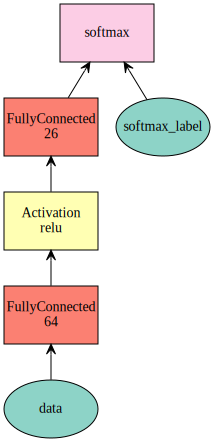

In [24]:
# Define the network
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=64)
net = mx.sym.Activation(data=net, name='relu1', act_type='relu')
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=26)
net = mx.sym.SoftmaxOutput(data=net, name='softmax')
mx.viz.plot_network(symbol=net)

In [25]:
# Creating a module
# -symbol: the network definition
# -context: the device (or a list of devices) to use for execution
# -data_names: the list of input data variable names
# -label_names: the list of input label variable names

mod = mx.mod.Module(symbol=net, 
                    context=mx.cpu(),
                    data_names=['data'],
                    label_names=['softmax_label'])

In [29]:
# Run training and inference
# -bind: Prepares environment for the computation by allocating memory.
# -init_params: Assigns and initializes parameters.
# -init_optimizer: Initializes optimizers. Defaults to sgd.
# -metric.create: Creates evaluation metric from input metric name.
# -forward: Forward computation.
# -update_metric: Evaluates and accumulates evaluation metric on outputs of the last forward computation.
# -backward: Backward computation.
# -update: Updates parameters according to the installed optimizer and the gradients computed in the previous forward-backward batch.

# allocate memory given the input data and label shapes
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
# initialize parameters by uniform random numbers
mod.init_params(initializer=mx.init.Uniform(scale=.1))
# use SGD with learning rate 0.1 to train
mod.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate', 0.1), ))
# use accuracy as the metric
metric = mx.metric.create('acc')
# train 5 epochs, i.e. going over the data iter one pass
for epoch in range(5):
    train_iter.reset()
    metric.reset()
    for batch in train_iter:
        mod.forward(batch, is_train=True)      # compute predictions
        mod.update_metric(metric, batch.label) # accumulate prediction accuracy
        mod.backward()                         # compute gradients
        mod.update()                           # update parameters
    print('Epoch %s, Training %s' %((epoch+1), metric.get()))

/home/kevin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  


Epoch 1, Training ('accuracy', 0.909125)
Epoch 2, Training ('accuracy', 0.909)
Epoch 3, Training ('accuracy', 0.912)
Epoch 4, Training ('accuracy', 0.9105625)
Epoch 5, Training ('accuracy', 0.9144375)


In [31]:
# high-level Interface
# Train
# reset train_iter to the begining
train_iter.reset()

# create a module
mod = mx.mod.Module(symbol=net,
                    context=mx.cpu(),
                    data_names=['data'],
                    label_names=['softmax_label'])

# fit the module
mod.fit(train_data=train_iter, 
        eval_data=val_iter,
        optimizer='sgd',
        optimizer_params={'learning_rate':0.1},
        eval_metric='acc',
        num_epoch=8)

INFO:root:Epoch[0] Train-accuracy=0.376500
INFO:root:Epoch[0] Time cost=0.356
INFO:root:Epoch[0] Validation-accuracy=0.580500
INFO:root:Epoch[1] Train-accuracy=0.632000
INFO:root:Epoch[1] Time cost=0.311
INFO:root:Epoch[1] Validation-accuracy=0.674750
INFO:root:Epoch[2] Train-accuracy=0.697562
INFO:root:Epoch[2] Time cost=0.304
INFO:root:Epoch[2] Validation-accuracy=0.701500
INFO:root:Epoch[3] Train-accuracy=0.737062
INFO:root:Epoch[3] Time cost=0.527
INFO:root:Epoch[3] Validation-accuracy=0.738250
INFO:root:Epoch[4] Train-accuracy=0.767250
INFO:root:Epoch[4] Time cost=0.319
INFO:root:Epoch[4] Validation-accuracy=0.774750
INFO:root:Epoch[5] Train-accuracy=0.785687
INFO:root:Epoch[5] Time cost=0.319
INFO:root:Epoch[5] Validation-accuracy=0.786750
INFO:root:Epoch[6] Train-accuracy=0.805625
INFO:root:Epoch[6] Time cost=0.306
INFO:root:Epoch[6] Validation-accuracy=0.786750
INFO:root:Epoch[7] Train-accuracy=0.815375
INFO:root:Epoch[7] Time cost=0.306
INFO:root:Epoch[7] Validation-accuracy=0

In [35]:
# Predict and Evaluate
y = mod.predict(val_iter)
assert y.shape == (4000, 26)

In [41]:
# score
score = mod.score(eval_data=val_iter, eval_metric=['mse', 'acc'])
print('Accuracy score is %f' %(score[1][1]))

Accuracy score is 0.800750


In [42]:
# Save and Load
# construct a callback function to save checkpoints
model_prefix = 'mx_mlp'
checkpoint = mx.callback.do_checkpoint(model_prefix)

mod = mx.mod.Module(symbol=net)
mod.fit(train_iter, num_epoch=5, epoch_end_callback=checkpoint)

INFO:root:Epoch[0] Train-accuracy=0.082312
INFO:root:Epoch[0] Time cost=0.351
INFO:root:Saved checkpoint to "mx_mlp-0001.params"
INFO:root:Epoch[1] Train-accuracy=0.258750
INFO:root:Epoch[1] Time cost=0.306
INFO:root:Saved checkpoint to "mx_mlp-0002.params"
INFO:root:Epoch[2] Train-accuracy=0.440250
INFO:root:Epoch[2] Time cost=0.310
INFO:root:Saved checkpoint to "mx_mlp-0003.params"
INFO:root:Epoch[3] Train-accuracy=0.540312
INFO:root:Epoch[3] Time cost=0.490
INFO:root:Saved checkpoint to "mx_mlp-0004.params"
INFO:root:Epoch[4] Train-accuracy=0.607000
INFO:root:Epoch[4] Time cost=0.504
INFO:root:Saved checkpoint to "mx_mlp-0005.params"


In [43]:
# load checkpoint
sym, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, 3)
assert sym.tojson() == net.tojson()

# assign the loaded parameters to the module
mod.set_params(arg_params=arg_params, aux_params=aux_params)

In [44]:
# resume training from a saved checkpoint
mod = mx.mod.Module(symbol=sym)
mod.fit(train_iter, 
        num_epoch=8,
        arg_params=arg_params,
        aux_params=aux_params,
        begin_epoch=3)

INFO:root:Epoch[3] Train-accuracy=0.540312
INFO:root:Epoch[3] Time cost=0.389
INFO:root:Epoch[4] Train-accuracy=0.607000
INFO:root:Epoch[4] Time cost=0.320
INFO:root:Epoch[5] Train-accuracy=0.647312
INFO:root:Epoch[5] Time cost=0.307
INFO:root:Epoch[6] Train-accuracy=0.675312
INFO:root:Epoch[6] Time cost=0.324
INFO:root:Epoch[7] Train-accuracy=0.695875
INFO:root:Epoch[7] Time cost=0.497
